**Imports**

In [1]:
# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import seaborn as sns

# Goggle
from goggle.GoggleModel import GoggleModel

# Synthcity
from synthcity.plugins.core.dataloader import GenericDataLoader

/home/rob/miniconda3/envs/goggle10/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-03-07 14:44:32,417 - Created a temporary directory at /tmp/tmpuwukynce
2023-03-07 14:44:32,417 - Writing /tmp/tmpuwukynce/_remote_module_non_scriptable.py


**Load data**

In [2]:
dataset = "red_wine"
X = pd.read_csv("../data/winequality_red.csv")
ind = list(range(len(X.columns)))
ind = [x for x in ind if x != X.columns.get_loc("quality")]
col_list = X.columns[ind]
ct = ColumnTransformer(
    [("scaler", StandardScaler(), col_list)], remainder="passthrough"
)

X_ = ct.fit_transform(X)
X = pd.DataFrame(X_, index=X.index, columns=X.columns)

X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5.0
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,5.0
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,5.0
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,6.0
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5.0


**Fit model**

In [3]:
X_train, X_test = train_test_split(X, random_state=0, test_size=0.2, shuffle=True)

gen = GoggleModel(
    ds_name=dataset,
    input_dim=X_train.shape[1],
    encoder_dim=64,
    encoder_l=2,
    het_encoding=True,
    decoder_dim=64,
    decoder_l=2,
    threshold=0.05,
    decoder_arch="gcn",
    graph_prior=None,
    prior_mask=None,
    device="cpu",
    beta=0.01,
    learning_rate=0.01,
    seed=0,
)
gen.model

Goggle(
  (learned_graph): LearnedGraph(
    (act): Sigmoid()
    (threshold): Threshold(threshold=0.05, value=0)
  )
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=12, out_features=64, bias=True)
      (1): ReLU()
    )
    (encode_mu): Linear(in_features=64, out_features=12, bias=True)
    (encode_logvar): Linear(in_features=64, out_features=12, bias=True)
  )
  (graph_processor): GraphInputProcessorHomo()
  (decoder): GraphDecoderHomo(
    (decoder): Sequential(
      (0): GraphConv(
        in=64, out=32, normalization=both
        (_activation): Tanh()
      )
      (1): GraphConv(in=32, out=1, normalization=both, activation=None)
    )
  )
)

In [4]:
gen.fit(X_train)

[Epoch 100/1000, patience 10] train: 5.663, val: 5.651
[Epoch 200/1000, patience  1] train: 4.868, val: 4.512
[Epoch 300/1000, patience  0] train: 4.093, val: 3.825
[Epoch 400/1000, patience 27] train: 3.135, val: 3.120
Training terminated after 497 epochs


**Evaluate synthetic data**

In [5]:
X_synth = gen.sample(X_test)
X_synth.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.648927,-0.257048,-0.375740,-0.641256,0.117419,1.034932,1.195993,-0.138582,-1.111175,0.503078,-1.430732,5.0
1,0.706143,-0.318578,0.828060,1.348782,1.234751,0.736882,0.788651,0.787502,-0.602978,1.173028,-0.013647,6.0
2,-1.240022,0.895366,-0.707383,-0.970644,-1.365558,2.550232,2.615172,-0.735841,0.047510,-2.816531,-1.380443,4.0
3,-0.007910,0.116783,-0.027010,0.253034,-0.460810,-0.343469,-0.112937,-0.080699,-1.314394,-1.075447,-0.715642,5.0
4,0.208217,-0.577867,0.421466,0.841368,1.339731,0.614230,0.311945,0.730072,0.985339,1.169046,0.114816,6.0


In [6]:
X_synth_loader = GenericDataLoader(
    X_synth,
    target_column="quality",
)
X_test_loader = GenericDataLoader(
    X_test,
    target_column="quality",
)

res = gen.evaluate_synthetic(X_synth_loader, X_test_loader)
print(f"Quality: {res[0]:.3f}")
print(f"Detection: {res[2]:.3f}")
print(
    f"Performance on real: {res[1][0]:.3f}, on synth: {res[1][1]:.3f}, diff: {(res[1][0] - res[1][1]):.3f}"
)

Quality: 0.587
Detection: 0.741
Performance on real: 0.631, on synth: 0.643


**Generate TSNE plots**

In [7]:
X_test["label"] = "Original"
X_synth["label"] = "Synthetic"

concat_df = pd.concat([X_test, X_synth], axis=0)
y_data = concat_df["label"]
x_data = concat_df.drop(["label", "quality"], axis=1)

In [8]:
tsne = TSNE(n_components=2, verbose=0, random_state=0)
z = tsne.fit_transform(x_data)
df = pd.DataFrame()
df["y"] = y_data
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

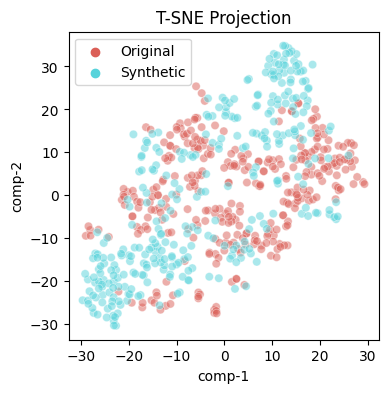

In [9]:
plt.figure(figsize=(4, 4))
sns.scatterplot(
    x="comp-1",
    y="comp-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 2),
    alpha=0.5,
    data=df,
).set(title=f"T-SNE Projection")
plt.xlabel("comp-1")
plt.ylabel("comp-2")
plt.legend()

plt.show()

**Visualise adjacency matrix**

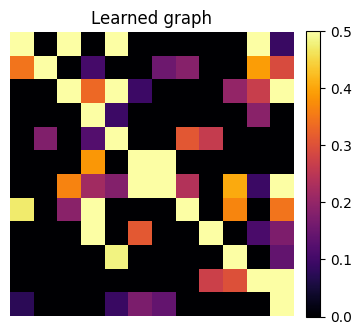

In [10]:
adj_matrix = gen.model.learned_graph(100).cpu().detach().numpy()
plt.figure(figsize=(4, 4))
im = plt.imshow(adj_matrix, cmap="inferno", interpolation="nearest", vmin=0, vmax=0.5)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Learned graph")
plt.axis("off")
plt.show()